Dataset: https://www.kaggle.com/datasets/die9origephit/nike-adidas-and-converse-imaged/data

Importar Librerías

In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

Cargar conjunto de datos , Normalización y Construcción modelo

In [2]:
# Descomprimir el archivo ZIP
import zipfile
import os

zip_path = '/content/Shoes.zip'  # Reemplaza con la ruta de tu archivo ZIP
extract_path = '/content/shoes_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verificar la estructura de directorios
os.listdir(extract_path)

['train', 'test']

In [3]:
# Preparar los datos usando ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ruta a las carpetas de entrenamiento y prueba
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')


In [4]:
from PIL import Image, ImageEnhance
# Función para aplicar transformaciones a una imagen
# Función para aplicar transformaciones a una imagen
def transform_image(image):
    # Aplicar rotación
    rotated = image.rotate(30)  # Rota la imagen 30 grados
    # Aplicar aumento de nitidez
    enhanced = ImageEnhance.Sharpness(image).enhance(2)  # Aumenta la nitidez
    # Aplicar reflexión horizontal
    flipped = image.transpose(Image.FLIP_LEFT_RIGHT)  # Reflexión horizontal
    # Aplicar cambio de contraste
    contrasted = ImageEnhance.Contrast(image).enhance(1.5)  # Aumenta el contraste

    return rotated, enhanced, flipped, contrasted

# Recorrer todas las subcarpetas en el directorio principal
for subfolder in os.listdir(train_dir):
    subfolder_path = os.path.join(train_dir, subfolder)

    if os.path.isdir(subfolder_path):  # Verificar que es una carpeta
        print(f'Procesando carpeta: {subfolder}')

        # Procesar imágenes en la subcarpeta
        for filename in os.listdir(subfolder_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filtrar por tipo de archivo
                image_path = os.path.join(subfolder_path, filename)

                try:
                    with Image.open(image_path) as img:
                        #Aplicar las transformaciones
                        rotated_img, enhanced_img, flipped_img, contrasted_img = transform_image(img)

                        # Crear nombres de archivos para las imágenes transformadas
                        base_name, ext = os.path.splitext(filename)
                        rotated_filename = f'{base_name}_rotated{ext}'
                        enhanced_filename = f'{base_name}_enhanced{ext}'
                        flipped_filename = f'{base_name}_flipped{ext}'
                        contrasted_filename = f'{base_name}_contrasted{ext}'

                        # Guardar las imágenes transformadas en la subcarpeta de salida
                        rotated_img.save(os.path.join(subfolder_path, rotated_filename))
                        enhanced_img.save(os.path.join(subfolder_path, enhanced_filename))
                        flipped_img.save(os.path.join(subfolder_path, flipped_filename))
                        contrasted_img.save(os.path.join(subfolder_path, contrasted_filename))

                        #print(f'Imágenes transformadas guardadas: {rotated_filename}, {enhanced_filename}, {flipped_filename}, {contrasted_filename}')


                except Exception as e:
                    print(f'Error procesando {filename}: {e}')

print("Transformaciones completadas.")

Procesando carpeta: adidas
Procesando carpeta: nike
Procesando carpeta: converse
Transformaciones completadas.


In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),  # Ajusta el tamaño de las imágenes
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),  # Ajusta el tamaño de las imágenes
    batch_size=32,
    class_mode='categorical'
)
# Extraer datos y etiquetas de los generadores
training_images, training_labels = next(train_generator)
test_images, test_labels = next(test_generator)
print(training_images.shape)
print(test_images.shape)

Found 3555 images belonging to 3 classes.
Found 114 images belonging to 3 classes.
(32, 64, 64, 3)
(32, 64, 64, 3)


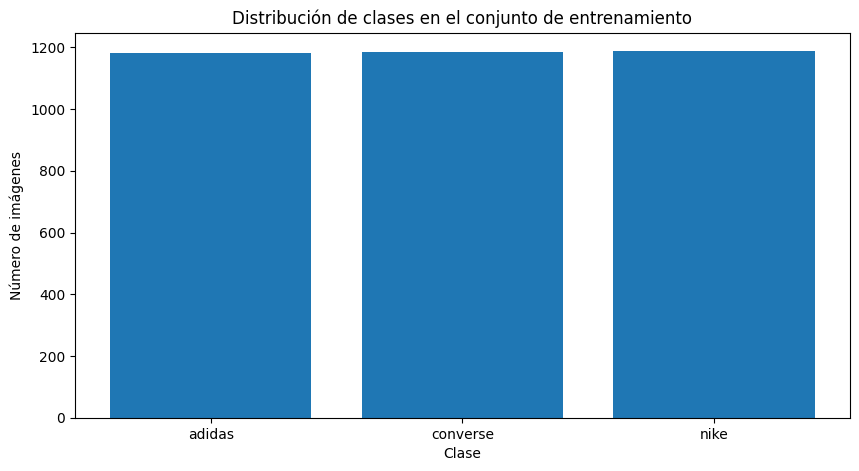

In [7]:
# Obtener etiquetas de las imágenes en el generador de datos de entrenamiento
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}  # Invertir el diccionario para obtener las etiquetas de clase

# Contar el número de imágenes en cada clase
class_counts = np.zeros(len(class_labels))
for i in range(len(train_generator)):
    images, labels = next(train_generator)
    class_counts += labels.sum(axis=0)

# Generar gráfico de barras
plt.figure(figsize=(10, 5))
plt.bar(range(len(class_labels)), class_counts, tick_label=list(class_labels.values()))
plt.xlabel('Clase')
plt.ylabel('Número de imágenes')
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.show()

In [81]:
# Construir el modelo de clasificacion.
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Construir el modelo de clasificacion.
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(64,64, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.25),
    Dense(3, activation='softmax')
])


model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 31, 31, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_54 (Dropout)        (None, 31, 31, 64)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_55 (Dropout)        (None, 14, 14, 64)       

Compilación del modelo

In [82]:
# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

Entrenamiento del modelo

Epoch 1/90
1/1 [==============================] - 2s 2s/step - loss: 2.1272 - accuracy: 0.2812
Epoch 2/90
1/1 [==============================] - 0s 340ms/step - loss: 2.0684 - accuracy: 0.3750
Epoch 3/90
1/1 [==============================] - 0s 347ms/step - loss: 2.0793 - accuracy: 0.2500
Epoch 4/90
1/1 [==============================] - 0s 365ms/step - loss: 2.0390 - accuracy: 0.5000
Epoch 5/90
1/1 [==============================] - 0s 355ms/step - loss: 2.1000 - accuracy: 0.3750
Epoch 6/90
1/1 [==============================] - 0s 382ms/step - loss: 2.0050 - accuracy: 0.4375
Epoch 7/90
1/1 [==============================] - 0s 355ms/step - loss: 2.0046 - accuracy: 0.4062
Epoch 8/90
1/1 [==============================] - 0s 331ms/step - loss: 1.9926 - accuracy: 0.3750
Epoch 9/90
1/1 [==============================] - 0s 356ms/step - loss: 1.9799 - accuracy: 0.3750
Epoch 10/90
1/1 [==============================] - 0s 341ms/step - loss: 2.0710 - accuracy: 0.2812
Epoch 11/90
1/1 [=====

<Axes: >

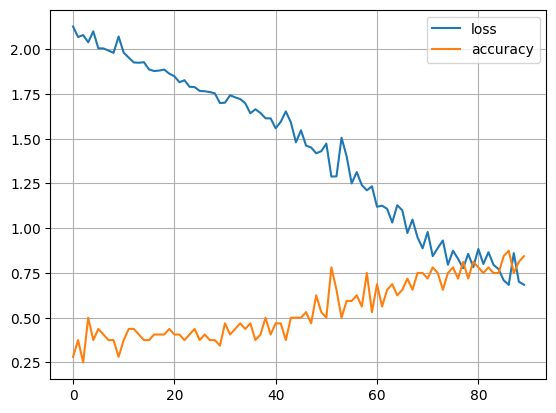

In [83]:
# Entrenar el modelo
history = model.fit(training_images,training_labels, epochs=90, batch_size=32)
# Graficar el historial de entrenamiento:
pd.DataFrame(history.history).plot(grid=True)

Evaluación del modelo

In [85]:
# Evaluar el modelo en el conjunto de entrenamiento
loss, accuracy = model.evaluate(training_images, training_labels)
print("Pérdida en el conjunto de entrenamiento:", loss)
print("Precisión en el conjunto de entrenamiento:", accuracy)

# Evaluar el modelo con datos no vistos
loss, accuracy = model.evaluate(test_images, test_labels)
print("Pérdida en el conjunto de prueba:", loss)
print ("Precisión en el conjunto de prueba:", accuracy)

1/1 [==============================] - 0s 100ms/step - loss: 0.6503 - accuracy: 0.9062
Pérdida en el conjunto de entrenamiento: 0.6502537131309509
Precisión en el conjunto de entrenamiento: 0.90625
1/1 [==============================] - 0s 100ms/step - loss: 2.2664 - accuracy: 0.5000
Pérdida en el conjunto de prueba: 2.266357660293579
Precisión en el conjunto de prueba: 0.5


Predicción

In [86]:
#predict

index = 1
print(f'Label: {test_labels[index]}')
classification = model.predict(test_images[index:index+1])
print(f'Classification:\n {classification.reshape(-1,1)}')

Label: [0. 0. 1.]
1/1 [==============================] - 0s 150ms/step
Classification:
 [[0.97947454]
 [0.00976679]
 [0.01075856]]


Preparación de datos

In [87]:
print(test_labels[:30])

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


Selección Imágenes de Interes

In [88]:
FIRST_IMAGE=0
SECOND_IMAGE=2
THIRD_IMAGE=3
print(test_labels[FIRST_IMAGE])
print(test_labels[SECOND_IMAGE])
print(test_labels[ THIRD_IMAGE])

[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]


Visualización de Imágenes

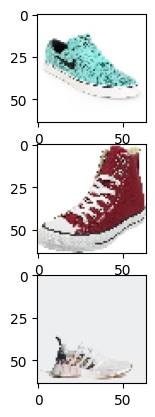

In [89]:
f, axarr = plt.subplots(3,1)
axarr[0].imshow(test_images[FIRST_IMAGE])
axarr[1].imshow(test_images[SECOND_IMAGE])
axarr[2].imshow(test_images[THIRD_IMAGE])

Extracción de activaciones

In [90]:
layer = 0
filter1 = 0
filter2 = 10
layer_outputs = [layer.output for layer in model.layers]
activation_model = keras.models.Model(inputs = model.input, outputs = layer_outputs)

Visualización de Convoluciones

1/1 [==============================] - 0s 32ms/step


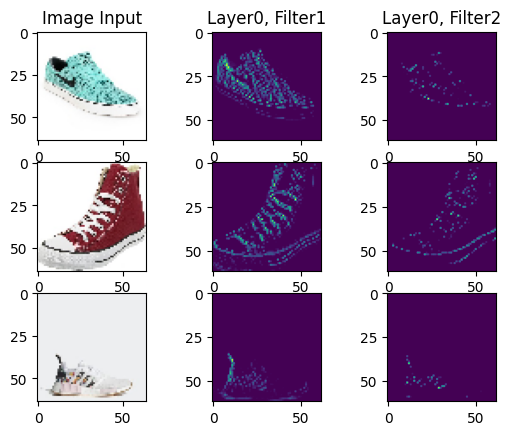

In [91]:
f, axarr = plt.subplots(3,3)
axarr[0, 0].set_title("Image Input")
axarr[0,0]. imshow(test_images[FIRST_IMAGE])

f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 64, 64, 3))[layer]
axarr[0, 1].set_title("Layer"+ str(layer) +", Filter1")
axarr[0,1].imshow(f1[0, : , :, filter1])
axarr[0,2].set_title("Layer"+ str(layer) +", Filter2")
axarr[0,2].imshow(f1[0, : , :, filter2])
axarr[1,0].imshow(test_images[SECOND_IMAGE])

f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 64, 64, 3))[layer]
axarr[1,1].imshow(f2[0, : , :, filter1])
axarr[1,2]. imshow(f2[0, : , :, filter2])
axarr[2,0].imshow(test_images[THIRD_IMAGE])

f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 64, 64, 3))[layer]
axarr[2,1].imshow(f3[0, : , :, filter1])
axarr[2,2].imshow(f3[0, : , :, filter2])

1/1 [==============================] - 0s 112ms/step


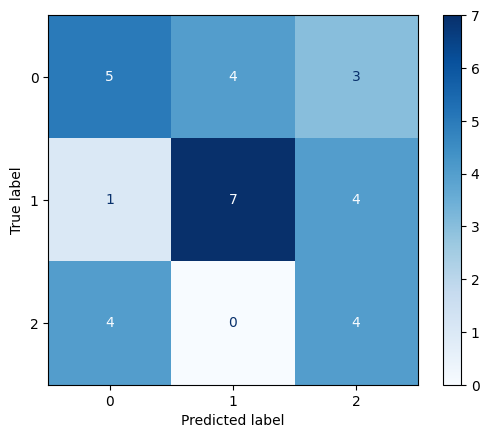

In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Obtener las predicciones del modelo
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = np.argmax(test_labels, axis=1)

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(true_classes))
disp.plot(cmap=plt.cm.Blues)
plt.show()

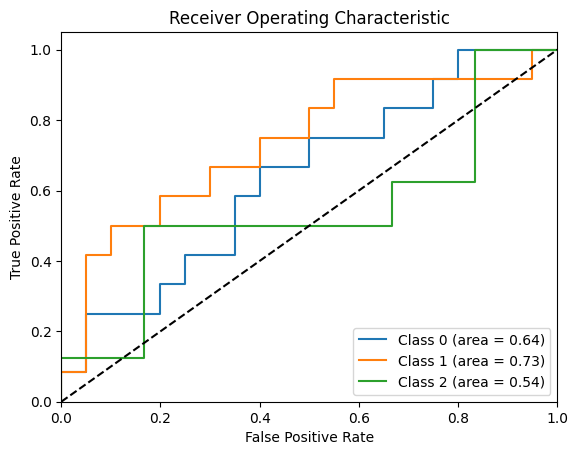

In [93]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# Binarizar las etiquetas verdaderas para calcular la curva ROC de cada clase
n_classes = test_labels.shape[1]
true_classes_binarized = label_binarize(true_classes, classes=[0, 1, 2])

# Calcular y visualizar la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotear todas las curvas ROC
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [94]:
from sklearn.metrics import f1_score
# Calcular el F1 Score
f1 = f1_score(true_classes, predicted_classes, average='weighted')
print(f'F1 Score: {f1}')

F1 Score: 0.5039785729144997
